<IPython.core.display.Javascript object>


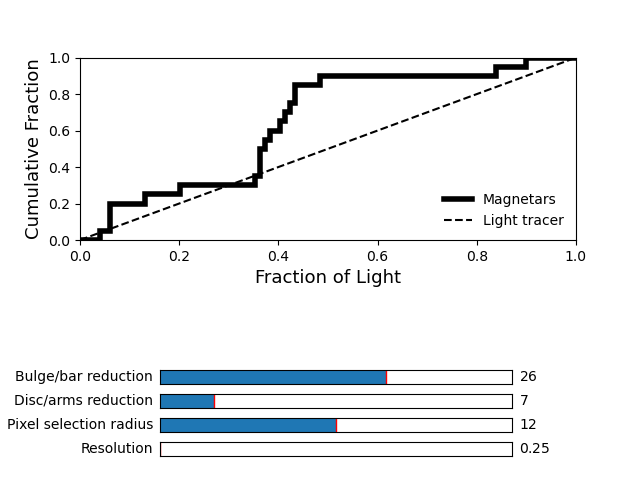

0

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.ndimage
from matplotlib.widgets import Slider
from matplotlib.widgets import Button

mcgill = pd.read_csv('TabO1.csv')
MWmagnetars = mcgill         
distances = MWmagnetars.Dist.values

maxdistlim = 20 #kpc
names = MWmagnetars.Name.values[(distances > 0) & (distances < maxdistlim)]
xmag = np.loadtxt('mcgill_x.txt')[(distances > 0) & (distances < maxdistlim)]
ymag = np.loadtxt('mcgill_y.txt')[(distances > 0) & (distances < maxdistlim)]   
hmag = np.loadtxt('mcgill_h.txt')[(distances > 0) & (distances < maxdistlim)]   
derrup = MWmagnetars.Dist_EUp.values[(distances > 0) & (distances < maxdistlim)]
derrlo = MWmagnetars.Dist_EDn.values[(distances > 0) & (distances < maxdistlim)]
dmag = distances[(distances > 0) & (distances < maxdistlim)]

ycut = 8.3  
names = names[(ymag<ycut)]
derrup = derrup[(ymag<ycut)]
derrlo = derrlo[(ymag<ycut)]
xmag = xmag[(ymag<ycut)]
hmag = hmag[(ymag<ycut)]  
dmag = dmag[(ymag<ycut)]
ymag = ymag[(ymag<ycut)]  

### Arms & sprinkles, output from galactic_magnetars.py and the Reid et al. 2019 methodology.
reid_sprinkle_x = np.loadtxt('reid_and_sprinkles_x.txt')
reid_sprinkle_y = np.loadtxt('reid_and_sprinkles_y.txt')
reid_sprinkle_h = np.loadtxt('reid_and_sprinkles_h.txt')
reid_sprinkle_lbol = np.loadtxt('reid_and_sprinkles_bol.txt')

######## Comparison data
flight_compare = np.loadtxt('comparison_flight_data.txt',skiprows=2)
# 0 = FRBs - IR - Mannings et al. 2020
# 1 = FRBs - UV - Mannings et al. 2020
# 2 = Light
# 3 = LGRBs - IR/UVIS - Blanchard et al. 2016
# 4 = Blanchard et al. 2016 LGRB redshift
# 5 = Blanchard et al. 2016 LGRB band (UVIS or IR) - IR is 0, UVIS is 1
# 6 = LGRBs - IR - Lyman et al. 2017
# 7 = SGRBs - IR/UVIS - Fong & Berger 2013 (inc. Fong et al. 2010)
# 8 = Fong & Berger 2013 SGRB band (UVIS or IR) - IR is 0, UVIS is 1
# 9 = Type Ia SNe - u - Wang et al. 2013
# 10 = Type Ia SNe - g - Wang et al. 2013
# 11 = Type Ia SNe - r - Wang et al. 2013
# 12 = CCSNe - IR - Svensson et al. 2010
# 13 = SLSNe - UV - Lunnan et al. 2015
# 14 = Random B (calculated in _5.py)
# 15 = Random I (calculated in _5.py)


#-------------------------------------------------------------------------------------------------------------#
############### FRACTIONAL LIGHT #########################################################
#-------------------------------------------------------------------------------------------------------------#

colour = 'B'
ks = np.empty((7,3))
fluxreduxlist = [1]        #distance no longer being altered, all at z = 0.25

fig = plt.figure()
plt.subplots_adjust(bottom=0.5)
ax = fig.subplots()
p = ax.plot([-1,-2],[0,1])
ax_slide = plt.axes([0.25, 0.1, 0.55, 0.03]) 
s_factor = Slider(ax_slide, 'Pixel selection radius', 0.3*30, 0.5*30, valinit=0.4*30, valstep=0.01*30)

ax_slide2 = plt.axes([0.25, 0.05, 0.55, 0.03])
s_factor2 = Slider(ax_slide2, 'Resolution', 30/120, 30/15, valinit=30/120, valstep=0.05)

ax_slide3 = plt.axes([0.25, 0.15, 0.55, 0.03])
s_factor3 = Slider(ax_slide3, 'Disc/arms reduction', 1, 40, valinit=7, valstep=1)

ax_slide4 = plt.axes([0.25, 0.2, 0.55, 0.03])
s_factor4 = Slider(ax_slide4, 'Bulge/bar reduction', 1, 40, valinit=26, valstep=1)

magnetarflightlist = np.empty((20,3))    #might need to adjust if mag are added/remover

###########original
circlecut = s_factor.val/30
C = 0
Res = int(30/(s_factor2.val) - 1)
Noisegrid = np.ones((Res+1,Res+1))  


armdisc_redux = s_factor3.val
bulgebar_redux = s_factor4.val
## Flux level reduction
fluxredux = fluxreduxlist[C]

arms = np.loadtxt('Fullmap/Arms_'+str(Res)+'.txt')/(fluxredux*armdisc_redux)
disc_in = np.loadtxt('Fullmap/Disc_'+str(Res)+'.txt')/(fluxredux*armdisc_redux)
disc = scipy.ndimage.gaussian_filter(disc_in,sigma=5)
barbulge = np.loadtxt('Fullmap/Barbulge_'+str(Res)+'.txt')/(fluxredux*bulgebar_redux)

Resgrid = Noisegrid + arms + disc + barbulge

R = 30/(Res+1)

shiftedx = (xmag[1:21]/R + Res/2)
shiftedy = ((ymag[1:21]-8.2)/R + Res/2)

# Get all pixel z values and sorting them into increasing order.
zlist = []
rlist = []
indicies = []
II = 0
mask = np.ones((Res+1,Res+1))      #Res+1/2 for half galaxy
indexes = np.linspace(0,Res,Res+1).astype(int)
for valx in indexes:
    for valy in indexes:   #add [0:np.int((Res+1)/2)] for Flight on half Galax only
        zlist = zlist + [Resgrid[valy,valx]]   #y,x is correct! Verified by blurred plotting above and mask below.
        rval = np.sqrt((valx-(Res+1)/2)**2 + (valy-(Res+1)/2)**2)
        rlist = rlist + [rval] #radial distance from centre of image
        indicies.append(II)
        if rval < circlecut*(Res+1):    # and valy > int((Res+1)/2):   #y is actually y, as confirmed by cyan plotting above. 
            mask[valy,valx] = np.nan
        II = II + 1
zlist = np.array(zlist)
rlist = np.array(rlist)
indicies = np.array(indicies)


indicies = indicies[rlist < circlecut*(Res+1)]    #a circle 24kpc wide - selecting the indicies that satisify this
zlist = zlist[rlist < circlecut*(Res+1)]   #3 sigma, rather than 5 connected 1 sigma, again, z values in this circle
zsort, indexsort = zip(*sorted(zip(zlist,indicies)))    #indicies sorted by z value

zsort = np.array(zsort)
flcumul = []
cflux = 0
for entry in zsort:
    cflux = cflux + entry
    flcumul.append(cflux)
flight_masers = np.array(flcumul)/np.max(flcumul)  #every pixel gets assigned a value from 0 to 1

# Ordering x,y PIXEL coordinates so that each z value has a coordinate pair in the same order as z and the indicies
xlist = []
ylist = []
c = 0
for Xx in indexes:
    for Yy in indexes:    #add [0:np.int((Res+1)/2)] for Flight on half Galax only
        if c in indicies:  #i.e. if this index  appears amongst those above the noise
            xlist.append(Xx)
            ylist.append(Yy)  
        c = c + 1
zsort, xsort = zip(*sorted(zip(zlist, xlist))) 
zsort, ysort = zip(*sorted(zip(zlist, ylist))) 
#x and y now ordered the same as z (increasing z) and indexsort and flight_masers.
xsort = np.array(xsort)
ysort = np.array(ysort)


mgn = 0
bestdex = []
offthehost = []
for XM in shiftedx:
       diffx = (XM - (xsort))**2
       diffy = (shiftedy[mgn] - (ysort))**2   #shiftedx/y includes extra R/2 to shift magn coordinates to CENTER of the pixel
       dist = np.sqrt(diffx+diffy)
       gradshifted = np.sqrt( (XM - (Res+1)/2)**2 + (shiftedy[mgn] - (Res+1)/2)**2 )
       if gradshifted >= circlecut*(Res+1):  #outside the host? then use Flight = 0
           offthehost.append(mgn)
       bestdex.append(np.where(dist == np.min(dist))[0][0])  #indicies of the cells which are closest to each magnetar.
       mgn = mgn + 1
magnetar_flight = flight_masers[bestdex]  
magnetar_flight[offthehost] = 0
magnetarflightlist[:,C] = magnetar_flight

N,bins,patches = ax.hist(magnetar_flight,histtype='step',density=True,cumulative=True,bins=np.linspace(0,1,100),linewidth=4,color='k')
patches[0].set_xy(patches[0].get_xy()[:-1])
p, = ax.plot([0,1],[-1,-2],'-k',linewidth=4,label='Magnetars')

ax.set_xlabel('Fraction of Light',fontsize=13)
ax.set_ylabel('Cumulative Fraction',fontsize=13)
p, = ax.plot([0,1],[0,1],'--k',label='Light tracer')
ax.legend(loc=4,frameon=False)
ax.set(xlim=(0,1), ylim=(0,1))
#ax.set_title('Pixel selection radius = '+str(np.round(s_factor.val,2))+' kpc, Resolution = '+str(np.round(s_factor2.val,2))+' kpc/pixel')
    
    

def update(val):
    ax.clear()
    

    circlecut = s_factor.val/30
    C = 0
    Resin = 30/(s_factor2.val) - 1
    Reslist = np.array([14,29,59,89,119])
    Diff = np.ndarray.tolist(np.abs(Resin-Reslist))
    mindex = Diff.index(np.min(Diff))
    Res = int(Reslist[mindex])
    

    Noisegrid = np.ones((Res+1,Res+1))  

    armdisc_redux = s_factor3.val
    bulgebar_redux = s_factor4.val
    
    arms = np.loadtxt('Fullmap/Arms_'+str(Res)+'.txt')/(armdisc_redux)
    disc_in = np.loadtxt('Fullmap/Disc_'+str(Res)+'.txt')/(armdisc_redux)
    disc = scipy.ndimage.gaussian_filter(disc_in,sigma=5)
    barbulge = np.loadtxt('Fullmap/Barbulge_'+str(Res)+'.txt')/(bulgebar_redux)
    
    Resgrid = Noisegrid + arms + disc + barbulge
    
    R = 30/(Res+1)
    
    shiftedx = (xmag[1:21]/R + Res/2)
    shiftedy = ((ymag[1:21]-8.2)/R + Res/2)
    
    # Get all pixel z values and sorting them into increasing order.
    zlist = []
    rlist = []
    indicies = []
    II = 0
    mask = np.ones((Res+1,Res+1))      #Res+1/2 for half galaxy
    indexes = np.linspace(0,Res,Res+1).astype(int)
    for valx in indexes:
        for valy in indexes:   #add [0:np.int((Res+1)/2)] for Flight on half Galax only
            zlist = zlist + [Resgrid[valy,valx]]   #y,x is correct! Verified by blurred plotting above and mask below.
            #plt.plot(valx,valy,'.c')    #
            rval = np.sqrt((valx-(Res+1)/2)**2 + (valy-(Res+1)/2)**2)
            rlist = rlist + [rval] #radial distance from centre of image
            indicies.append(II)
            if rval < circlecut*(Res+1):    # and valy > int((Res+1)/2):   #y is actually y, as confirmed by cyan plotting above. 
                mask[valy,valx] = np.nan
            II = II + 1
    zlist = np.array(zlist)
    rlist = np.array(rlist)
    indicies = np.array(indicies)
    
    indicies = indicies[rlist < circlecut*(Res+1)]    #a circle 24kpc wide - selecting the indicies that satisify this
    zlist = zlist[rlist < circlecut*(Res+1)]   #3 sigma, rather than 5 connected 1 sigma, again, z values in this circle
    zsort, indexsort = zip(*sorted(zip(zlist,indicies)))    #indicies sorted by z value
    
    zsort = np.array(zsort)
    flcumul = []
    cflux = 0
    for entry in zsort:
        cflux = cflux + entry
        flcumul.append(cflux)
    flight_masers = np.array(flcumul)/np.max(flcumul)  #every pixel gets assigned a value from 0 to 1
    
    # Ordering x,y PIXEL coordinates so that each z value has a coordinate pair in the same order as z and the indicies
    xlist = []
    ylist = []
    c = 0
    for Xx in indexes:
        for Yy in indexes:    #add [0:np.int((Res+1)/2)] for Flight on half Galax only
            if c in indicies:  #i.e. if this index  appears amongst those above the noise
                xlist.append(Xx)
                ylist.append(Yy)  
            c = c + 1
    zsort, xsort = zip(*sorted(zip(zlist, xlist))) 
    zsort, ysort = zip(*sorted(zip(zlist, ylist))) 

    xsort = np.array(xsort)
    ysort = np.array(ysort)
    
    mgn = 0
    bestdex = []
    offthehost = []
    for XM in shiftedx:
           diffx = (XM - (xsort))**2
           diffy = (shiftedy[mgn] - (ysort))**2   #shiftedx/y includes extra R/2 to shift magn coordinates to CENTER of the pixel
           dist = np.sqrt(diffx+diffy)
           gradshifted = np.sqrt( (XM - (Res+1)/2)**2 + (shiftedy[mgn] - (Res+1)/2)**2 )
           if gradshifted >= circlecut*(Res+1):  #outside the host? then use Flight = 0
               offthehost.append(mgn)
           bestdex.append(np.where(dist == np.min(dist))[0][0])  #indicies of the cells which are closest to each magnetar.
           mgn = mgn + 1
    magnetar_flight = flight_masers[bestdex]  
    magnetar_flight[offthehost] = 0
    magnetarflightlist[:,C] = magnetar_flight
    
    N,bins,patches = ax.hist(magnetar_flight,histtype='step',density=True,cumulative=True,bins=np.linspace(0,1,100),linewidth=4,color='k')
    patches[0].set_xy(patches[0].get_xy()[:-1])
    ax.plot([0,1],[-1,-2],'-k',linewidth=4,label='Magnetars')
    
    ax.set_xlabel('Fraction of Light',fontsize=13)
    ax.set_ylabel('Cumulative Fraction',fontsize=13)
    ax.plot([0,1],[0,1],'--k',label='Light tracer')
    ax.legend(loc=4,frameon=False)
    ax.set(xlim=(0,1), ylim=(0,1))
    #ax.set_title('Pixel selection radius = '+str(np.round(s_factor.val,2))+' kpc, Resolution = '+str(np.round(s_factor2.val,2))+' kpc/pixel')
  


s_factor.on_changed(update)
s_factor2.on_changed(update)
s_factor3.on_changed(update)
s_factor4.on_changed(update)